In [1]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ujson


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
with open('test4.json','r') as y:
    data=ujson.load(y)
    data=pd.DataFrame(data["DailyInfo"])

In [3]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [4]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    # First try an O(n) time, O(1) space solution for the common case that
    # everything is finite; fall back to O(n) space np.isfinite to prevent
    # false positives from overflow in sum method.
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)

In [6]:
    # data = pdr.get_data_yahoo(['V'],'2018-1-01','2022-01-28')
    # data = data[["close"]].copy()
    # data["returns"]=data.close.pct_change()
    # data["log_returns"]=np.log(1+data["returns"])
    
data.info() 
data["target"]=data.logreturn.shift(-1)
data.dropna(inplace=True)


    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5542 entries, 0 to 5541
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             5542 non-null   object 
 1   surprise         5542 non-null   float64
 2   surprise %       5542 non-null   float64
 3   EPS              5542 non-null   float64
 4   EPS estimate     5542 non-null   float64
 5   fiscal Date End  5542 non-null   object 
 6   adj close        5542 non-null   float64
 7   close            5542 non-null   float64
 8   open             5542 non-null   float64
 9   high             5542 non-null   float64
 10  low              5542 non-null   float64
 11  volume           5542 non-null   float64
 12  return           5542 non-null   float64
 13  logreturn        5542 non-null   float64
 14  EMA              5542 non-null   float64
 15  RSI              5542 non-null   float64
 16  AROONOSC         5542 non-null   float64
 17  SlowD         

In [7]:
data = data.drop('close', 1)
data = data.drop('fiscal Date End', 1)
data.drop(data.head(50).index,inplace = True)
data.info()

data.head(10)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5491 entries, 50 to 5540
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5491 non-null   object 
 1   surprise      5491 non-null   float64
 2   surprise %    5491 non-null   float64
 3   EPS           5491 non-null   float64
 4   EPS estimate  5491 non-null   float64
 5   adj close     5491 non-null   float64
 6   open          5491 non-null   float64
 7   high          5491 non-null   float64
 8   low           5491 non-null   float64
 9   volume        5491 non-null   float64
 10  return        5491 non-null   float64
 11  logreturn     5491 non-null   float64
 12  EMA           5491 non-null   float64
 13  RSI           5491 non-null   float64
 14  AROONOSC      5491 non-null   float64
 15  SlowD         5491 non-null   float64
 16  SlowK         5491 non-null   float64
 17  FastD         5491 non-null   float64
 18  FastK         5491 non-null

/var/folders/zd/psj4nyss2078dmjzlbbmw5c40000gn/T/ipykernel_74790/1090152859.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('close', 1)
/var/folders/zd/psj4nyss2078dmjzlbbmw5c40000gn/T/ipykernel_74790/1090152859.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('fiscal Date End', 1)


,Date,surprise,surprise %,EPS,EPS estimate,adj close,open,high,low,volume,...,AROONOSC,SlowD,SlowK,FastD,FastK,MACD_Signal,MACD,MACD_Hist,ROC,target
50,2000-03-30,0.01,33.3333,0.04,0.03,0.961397,1.192522,1.229353,1.119978,414400000.0,...,50.0,36.8759,18.1926,18.1926,1.6054,0.0354,0.0475,0.0122,3.4469,0.076980
51,2000-03-31,0.01,33.3333,0.04,0.03,1.038328,1.137835,1.225446,1.125000,404633600.0,...,40.0,26.4429,22.6858,22.6858,53.7027,0.0383,0.0539,0.0156,8.6480,-0.018580
52,2000-04-03,0.01,33.3333,0.04,0.03,1.019215,1.209821,1.245536,1.155692,328563200.0,...,20.0,25.0519,34.2774,34.2774,47.5242,0.0417,0.0547,0.0130,8.3821,-0.046051
53,2000-04-04,0.01,33.3333,0.04,0.03,0.973343,1.184152,1.187500,1.042411,660329600.0,...,-80.0,35.3927,49.2148,49.2148,46.4176,0.0444,0.0520,0.0076,-5.6544,0.023770
54,2000-04-05,0.01,33.3333,0.04,0.03,0.996757,1.129185,1.186384,1.107143,457665600.0,...,-80.0,44.9256,51.2846,51.2846,59.9121,0.0466,0.0521,0.0055,-9.5776,-0.040602
55,2000-04-06,0.01,33.3333,0.04,0.03,0.957097,1.166295,1.200893,1.100446,259627200.0,...,-80.0,49.4363,47.8095,47.8095,37.0989,0.0479,0.0474,-0.0005,-11.4075,0.051093
56,2000-04-07,0.01,33.3333,0.04,0.03,1.007269,1.136161,1.177455,1.120536,242435200.0,...,-60.0,51.1364,54.3150,54.3150,65.9341,0.0475,0.0366,-0.0109,-5.0040,-0.052593
57,2000-04-10,0.01,33.3333,0.04,0.03,0.955663,1.175781,1.185268,1.113839,212262400.0,...,-60.0,50.6539,49.8373,49.8373,46.4789,0.0460,0.0271,-0.0190,-10.4328,-0.045520
58,2000-04-11,0.01,33.3333,0.04,0.03,0.913136,1.102679,1.114955,1.054129,541822400.0,...,-50.0,48.1404,40.2690,40.2690,8.3942,0.0431,0.0166,-0.0265,-14.1522,-0.089155
59,2000-04-12,0.01,33.3333,0.04,0.03,0.835249,1.062500,1.062500,0.936384,941136000.0,...,-70.0,37.7749,23.2184,23.2184,14.7823,0.0380,0.0013,-0.0366,-19.6337,0.040914


In [9]:
# X_scaled=data[["Close","log_returns","target"]].values
data = data.drop('Date', 1)
data=clean_dataset(data)


/var/folders/zd/psj4nyss2078dmjzlbbmw5c40000gn/T/ipykernel_74790/644264090.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop('Date', 1)


In [10]:
_assert_all_finite(data)

In [11]:
X_scaled=pd.DataFrame(data)
X_scaled.info()
X_scaled.tail(2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5491 entries, 50 to 5540
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   surprise      5491 non-null   float64
 1   surprise %    5491 non-null   float64
 2   EPS           5491 non-null   float64
 3   EPS estimate  5491 non-null   float64
 4   adj close     5491 non-null   float64
 5   open          5491 non-null   float64
 6   high          5491 non-null   float64
 7   low           5491 non-null   float64
 8   volume        5491 non-null   float64
 9   return        5491 non-null   float64
 10  logreturn     5491 non-null   float64
 11  EMA           5491 non-null   float64
 12  RSI           5491 non-null   float64
 13  AROONOSC      5491 non-null   float64
 14  SlowD         5491 non-null   float64
 15  SlowK         5491 non-null   float64
 16  FastD         5491 non-null   float64
 17  FastK         5491 non-null   float64
 18  MACD_Signal   5491 non-null

,surprise,surprise %,EPS,EPS estimate,adj close,open,high,low,volume,return,...,AROONOSC,SlowD,SlowK,FastD,FastK,MACD_Signal,MACD,MACD_Hist,ROC,target
5539,0.002,0.1616,1.24,1.238,161.414337,160.020004,162.300003,154.699997,162294600.0,-0.004864,...,-70.0,6.5449,14.1334,14.1334,38.7892,-0.9042,-3.5798,-2.6756,-6.1277,-0.011450
5540,0.002,0.1616,1.24,1.238,159.576691,158.979996,162.759995,157.020004,115798400.0,-0.011385,...,-70.0,13.2613,23.5870,23.5870,31.0134,-1.5479,-4.1174,-2.5696,-7.2072,-0.000563


In [12]:
X, y = X_scaled.iloc[:,:-1],X_scaled.iloc[:,-1]
X.head(), y.head()
X.tail(), y.tail()




(      surprise  surprise %   EPS  EPS estimate   adj close        open  \
 5536     0.002      0.1616  1.24         1.238  166.018478  170.000000   
 5537     0.002      0.1616  1.24         1.238  164.300659  166.979996   
 5538     0.002      0.1616  1.24         1.238  162.203354  164.419998   
 5539     0.002      0.1616  1.24         1.238  161.414337  160.020004   
 5540     0.002      0.1616  1.24         1.238  159.576691  158.979996   
 
             high         low       volume    return  ...      RSI  AROONOSC  \
 5536  171.080002  165.940002   94815000.0 -0.021025  ...  13.5013    -100.0   
 5537  169.679993  164.179993   91420500.0 -0.010347  ...   4.6619    -100.0   
 5538  166.330002  162.300003  122848900.0 -0.012765  ...   2.2072     -60.0   
 5539  162.300003  154.699997  162294600.0 -0.004864  ...   0.7870     -70.0   
 5540  162.759995  157.020004  115798400.0 -0.011385  ...   0.6033     -70.0   
 
         SlowD    SlowK    FastD    FastK  MACD_Signal    MACD  MA

In [13]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [14]:
def train_test_split(data,perc):
    split=int(len(data)*perc)
    
    train=data[:split]
    test=data[split:len(data)]
    
    return train,test



In [15]:
def xgb_predict(train,val):
    # train=np.array(train)
    X, Y=train.iloc[:,:-1],train.iloc[:,-1] 
    model=XGBRegressor(objective="reg:squarederror")
    model.fit(X,Y)
    
    val=np.array(val).reshape(1,-1)
    
    pred=model.predict(val)
    return pred[0],model

In [16]:
def validate(data,perc):
    predictions=[]
    train,test = train_test_split(data, perc)
    history=train
    print(history)

    for i in range(len(test)):
        test_X,test_y=test.iloc[i,:-1],test.iloc[i,-1]
        test_X=np.array(test_X)
        
        # print(test_y,test_X)
        # print(predictions)
        pred,model=xgb_predict(history, test_X)
        # print(predictions)
        
        predictions.append(pred)    
    
        item1 = pd.Series(test.iloc[i,0])
        item2 = pd.Series(test.iloc[i,1])
        item3 = pd.Series(test.iloc[i,2])
        item4 = pd.Series(test.iloc[i,3])
        item5 = pd.Series(test.iloc[i,4])
        item6 = pd.Series(test.iloc[i,5])
        item7 = pd.Series(test.iloc[i,6])
        item8 = pd.Series(test.iloc[i,7])
        item9 = pd.Series(test.iloc[i,8])
        item10 = pd.Series(test.iloc[i,9])
        # item11= pd.Series(test.iloc[i,10])
        # item12= pd.Series(test.iloc[i,11])
        # item13 = pd.Series(test.iloc[i,12])
        # item14 = pd.Series(test.iloc[i,13])
        # item15= pd.Series(test.iloc[i,14])
        # item16= pd.Series(test.iloc[i,15])
        # item17= pd.Series(test.iloc[i,16])
        # item18= pd.Series(test.iloc[i,17])
        # item19= pd.Series(test.iloc[i,18])
        # item20 = pd.Series(test.iloc[i,19])
        # item21 = pd.Series(test.iloc[i,20])
        # item22= pd.Series(test.iloc[i,21])
        # item23= pd.Series(test.iloc[i,22])
        # item24= pd.Series(test.iloc[i,23])
# 0   adj close  492 non-null    float64
#  1   volume     492 non-null    float64
#  2   return     492 non-null    float64
#  3   logreturn  492 non-null    float64
#  4   RSI        492 non-null    float64
#  5   SlowK      492 non-null    float64
#  6   FastK      492 non-null    float64
#  7   MACD_Hist  492 non-null    float64
#  8   ROC        492 non-null    float64
#  9   target     492 non-null    float64
        
        ditem1= pd.DataFrame(item1)
        ditem2= pd.DataFrame(item2)
        ditem3= pd.DataFrame(item3)
        ditem4= pd.DataFrame(item4)
        ditem5= pd.DataFrame(item5)
        ditem6= pd.DataFrame(item6)
        ditem7= pd.DataFrame(item7)
        ditem8= pd.DataFrame(item8)
        ditem9= pd.DataFrame(item9)
        ditem10= pd.DataFrame(item10)
        # ditem11= pd.DataFrame(item11)
        # ditem12= pd.DataFrame(item12)
        # ditem13= pd.DataFrame(item13)
        # ditem14= pd.DataFrame(item14)
        # ditem15= pd.DataFrame(item15)
        # ditem16= pd.DataFrame(item16)
        # ditem17= pd.DataFrame(item17)
        # ditem18= pd.DataFrame(item18)
        # ditem19= pd.DataFrame(item19)
        # ditem20= pd.DataFrame(item20)
        # ditem21= pd.DataFrame(item21)
        # ditem22= pd.DataFrame(item22)
        # ditem23= pd.DataFrame(item23)
        # ditem24= pd.DataFrame(item24)
        
        ditem1 = ditem1.rename(columns = {0:"adj close"})            
        ditem2 = ditem2.rename(columns = {0:"volume"})              
        ditem3 = ditem3.rename(columns = {0:"return"}) 
        ditem4 = ditem4.rename(columns = {0:"logreturn"})              
        ditem5 = ditem5.rename(columns = {0:"RSI"})  
        ditem6 = ditem6.rename(columns = {0:"SlowK"})             
        ditem7 = ditem7.rename(columns = {0:"FastK"})
        ditem8 = ditem8.rename(columns = {0:"MACD_Hist"})               
        ditem9 = ditem9.rename(columns = {0:"ROC"}) 
        ditem10 = ditem10.rename(columns = {0:"target"})              
        # ditem11 = ditem11.rename(columns = {0:"target"})
        # ditem12 = ditem12.rename(columns = {0:"target"})               
        # ditem13 = ditem13.rename(columns = {0:"EMA"})  
        # ditem14 = ditem14.rename(columns = {0:"RSI"})             
        # ditem15 = ditem15.rename(columns = {0:"AROONOSC"})
        # ditem16 = ditem16.rename(columns = {0:"SlowD"})         
        # ditem17 = ditem17.rename(columns = {0:"SlowK"})      
        # ditem18 = ditem18.rename(columns = {0:"FastD"})      
        # ditem19 = ditem19.rename(columns = {0:"FastK"})         
        # ditem20 = ditem20.rename(columns = {0:"MACD_Signal"})     
        # ditem21 = ditem21.rename(columns = {0:"MACD"})          
        # ditem22 = ditem22.rename(columns = {0:"MACD_Hist"})   
        # ditem23 = ditem23.rename(columns = {0:"ROC"})
        # ditem24 = ditem24.rename(columns = {0:"target"})  
        items = pd.concat([ditem1, ditem2, ditem3, ditem4,ditem5,ditem6,ditem7,ditem8,ditem9,ditem10], axis=1)
        # ditem12,ditem13,ditem14,ditem15,ditem16,ditem17,ditem18,ditem19,ditem20,ditem21,ditem22,ditem23,ditem24
        # print(items) 
        history=history.append(items, ignore_index=True )
        # print(history.tail(1))
        
    error=mean_squared_error(test.iloc[:,-1],predictions,squared=False)
    return error,test.iloc[:,-1],predictions,model

In [17]:
rmse,y,pred,model=validate(X_scaled,0.8)
    


      surprise  surprise %     EPS  EPS estimate  adj close       open  \
50       0.010     33.3333  0.0400        0.0300   0.961397   1.192522   
51       0.010     33.3333  0.0400        0.0300   1.038328   1.137835   
52       0.010     33.3333  0.0400        0.0300   1.019215   1.209821   
53       0.010     33.3333  0.0400        0.0300   0.973343   1.184152   
54       0.010     33.3333  0.0400        0.0300   0.996757   1.129185   
...        ...         ...     ...           ...        ...        ...   
4437     0.025      6.3694  0.4175        0.3925  38.371010  40.522499   
4438     0.025      6.3694  0.4175        0.3925  37.745213  40.215000   
4439     0.025      6.3694  0.4175        0.3925  38.428127  40.125000   
4440     0.025      6.3694  0.4175        0.3925  38.275829  40.652500   
4441     0.025      6.3694  0.4175        0.3925  37.987926  39.967499   

           high        low       volume    return  ...  AROONOSC    SlowD  \
50     1.229353   1.119978  414400

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/var/folders/zd/psj4nyss2078dmjzlbbmw5c40000gn/T/ipykernel_74790/3245485775.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  history=history.append(items, ignore_index=True )
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/var/folders/zd/psj4nyss2078dmjzlbbmw5c40000gn/T/ipykernel_74790/3245485775.py:105: FutureWar

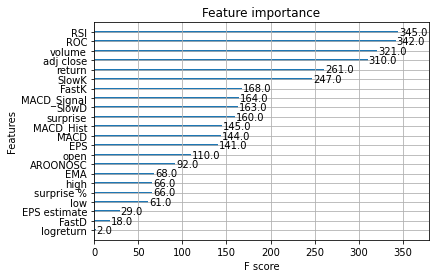

In [18]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [19]:
print(rmse)
print(y.tail(10))
size=len(pred)-1

for i in range(10):
    print(pred[size])
    size-=1





0.022853568435852484
5531    0.002567
5532   -0.019211
5533    0.005098
5534   -0.019075
5535   -0.021249
5536   -0.010401
5537   -0.012847
5538   -0.004876
5539   -0.011450
5540   -0.000563
Name: target, dtype: float64
0.001221176
0.02473924
0.025901161
0.016761975
-0.0034148411
0.0018210342
-0.0059366683
0.0014328782
0.0069204136
0.010869582


In [20]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 1000)

In [21]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)


In [22]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
45,0.026397,0.000933,0.026353,0.003392
46,0.026303,0.000937,0.026261,0.003398
47,0.026223,0.000940,0.026185,0.003409
48,0.026155,0.000943,0.026122,0.003417
49,0.026096,0.000946,0.026065,0.003420


In [23]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.026065
Name: test-rmse-mean, dtype: float64


In [29]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


In [30]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

ValueError: Booster.get_score() results in empty.  This maybe caused by having all trees as decision dumps.